# Verify a Presentation

## Before running this notebook you should have a mobile wallet contained the credential you issued yourself in Part 3. If not run through [Part 2](http://127.0.0.1:8888/notebooks/Part%202%20-%20Connecting%20Issuer%20Agent%20to%20Sovrin%20Stagingnet.ipynb) and [Part 3](http://localhost:8888/notebooks/Part%203%20-%20Issue%20Credential.ipynb) of this tutorial.

If unfamiliar with the present-proof protocol it is worth reading through the [aries-rfs](https://github.com/hyperledger/aries-rfcs/tree/master/features/0037-present-proof)


## Note that you do not need to write a public DID to the ledger as a verifier.

## 1. Instatiate Controller for Verifiers's Agent

In [1]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8042
WEBHOOK_BASE = ""
ADMIN_URL = "http://hee-agent:8041"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)


IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic present_proof, printing out the payload. The agent calls to this webhook every time it receives a present proof protocol message from another agent. 


In [2]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

def proof_handler(payload):
    print("Handle present proof")
    print(payload)

proof_listener = {
    "topic": "present_proof",
    "handler": proof_handler
}

agent_controller.register_listeners([connection_listener,proof_listener], defaults=True)



## 3. Make a connection with the Mobile SSI Wallet you used in [Part 2](http://127.0.0.1:8888/notebooks/Part%202%20-%20Connecting%20Issuer%20Agent%20to%20Sovrin%20Stagingnet.ipynb)

**You should have a credential stored in here from the previous notebook!**

Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 4. Create a connection invitation to scan with the Mobile SSI Wallet

## 4a. Check for any existing connections

In [10]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS
ConnectionID: ffb7355f-318c-4650-968b-a03abdc119d3 Status: invitation
ConnectionID: 9fe774db-9308-479a-adce-ef5a773e2ac9 Status: invitation


## 4b. Create an Invitation

In [11]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'updated_at': '2020-09-21 19:42:49.272354Z', 'invitation_mode': 'once', 'connection_id': 'ace4593e-e909-44fe-b823-cb82192053cb', 'invitation_key': '2D9reUwJY66kdTV9D3vHoXKYMqBYnBXYMrqxBv3MNbZb', 'initiator': 'self', 'accept': 'auto', 'routing_state': 'none', 'created_at': '2020-09-21 19:42:49.272354Z', 'state': 'invitation'} ace4593e-e909-44fe-b823-cb82192053cb
Connection ID ace4593e-e909-44fe-b823-cb82192053cb
Invitation
https://557f26f3963c.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiMDVmMDcxOGItOTZiZi00OTUxLWI0ZDQtNGY0ZGUxMzI2NjAxIiwgImxhYmVsIjogIkhlYWx0aCBFZHVjYXRpb24gRW5nbGFuZCIsICJzZXJ2aWNlRW5kcG9pbnQiOiAiaHR0cHM6Ly81NTdmMjZmMzk2M2Mubmdyb2suaW8iLCAicmVjaXBpZW50S2V5cyI6IFsiMkQ5cmVVd0pZNjZrZFRWOUQzdkhvWEtZTXFCWW5CWFlNcnF4QnYzTU5iWmIiXX0=


## 4c. Generate QR Code to be scanned with Mobile SSI Wallet

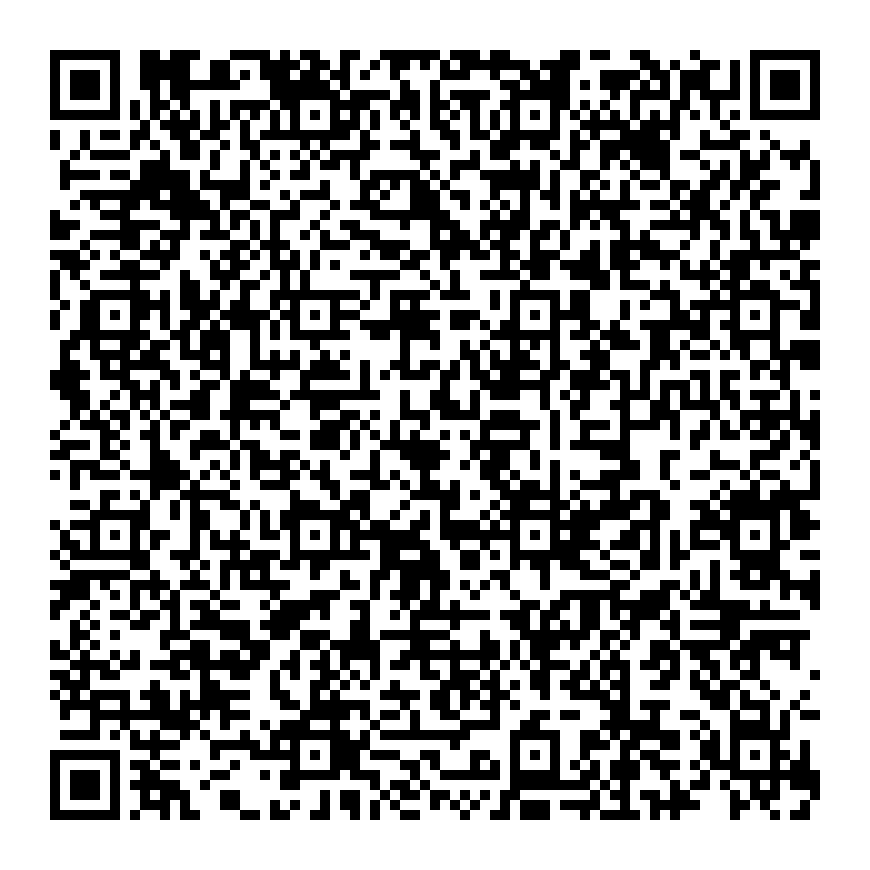

In [12]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('verifier_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./verifier_agent_invite_QRcode.png')

## 4d. Check if established connection is in active state

In [9]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId 9fe774db-9308-479a-adce-ef5a773e2ac9 is invitation
ConnectionId 9fe774db-9308-479a-adce-ef5a773e2ac9 is not in active state yet


ClientResponseError: 400, message='Connection 9fe774db-9308-479a-adce-ef5a773e2ac9 not ready', url=URL('http://hee-agent:8041/connections/9fe774db-9308-479a-adce-ef5a773e2ac9/send-ping')

ERROR:asyncio:Task exception was never retrieved
future: <Task finished coro=<run_in_terminal.<locals>.run() done, defined at /opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py:50> exception=UnsupportedOperation('fileno')>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py", line 55, in run
    return func()
  File "/aries_basic_controller/helpers/utils.py", line 120, in <lambda>
    run_in_terminal(lambda: print_ext(*msg, color=color, **kwargs))
  File "/aries_basic_controller/helpers/utils.py", line 103, in print_ext
    print_formatted(FormattedText(msg), **kwargs)
  File "/aries_basic_controller/helpers/utils.py", line 83, in print_formatted
    prompt_toolkit.print_formatted_text(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/shortcuts/utils.py", line 112, in print_formatted_text
    output = get_app_session().output
  File "/opt/conda/lib/

## 5. Send Proof Request to Identity Holder Mobile Wallet

## 5a. Generate Proof Request

The verifier will request a proof from the identity holder for the following attributes:

    fullname"
    "skill"
    "country" - self-attested
    "age" - as a predicate range proof to determine if the identity holder is older than 21


Note how the verifier has restricted the proof request to only include credentials issued against a specific `schema_id`. 

In our case `schema_id` = EuEtnVakYFyBtGFT1nHYtH:2:SSI PyDentity Tutorial:0.0.1

If you ledgered your own schema in [Part 2](http://127.0.0.1:8888/notebooks/Part%203%20-%20Issuer.ipynb) and didn't use the pre-ledgered schema then please copy the new schema_id into the `schemaid` variable in the cell below.

TODO: Add information around predicates

In [7]:
schema_id = 'EuEtnVakYFyBtGFT1nHYtH:2:SSI PyDentity Tutorial:0.0.1'

print("Request proof of Fullname and Age range from Identity Holder")
#Set some variables

revocation = False
SELF_ATTESTED = True
exchange_tracing = False

#Enable this to ask for attributes to identity a user
#TODO - change restriction to schemaId or credentialId

req_attrs = [
    {"name": "fullname", "restrictions": [{"schema_id": schema_id}]},
    {"name": "skill", "restrictions": [{"schema_id": schema_id}]},
]

if revocation:
    req_attrs.append(
        {
            "name": "skill",
            "restrictions": [{"schema_id": schema_id}],
            "non_revoked": {"to": int(time.time() - 1)},
        },
    )

if SELF_ATTESTED:
    # test self-attested claims
    req_attrs.append({"name": "country"},)

#Set predicates for Zero Knowledge Proofs
req_preds = [
    # test zero-knowledge proofs
    {
        "name": "age",
        "p_type": ">=",
        "p_value": 21,
        "restrictions": [{"schema_id": schema_id}],
    }
]

indy_proof_request = {
    "name": "Proof of Completion of PyDentity SSI Tutorial",
    "version": "1.0",
    "requested_attributes": {
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
    },
    "requested_predicates": {
        f"0_{req_pred['name']}_GE_uuid":
        req_pred for req_pred in req_preds
    },
}

if revocation:
    indy_proof_request["non_revoked"] = {"to": int(time.time())}

#proof_request = indy_proof_request
exchange_tracing_id = exchange_tracing
proof_request_web_request = {
    "connection_id": connection_id,
    "proof_request": indy_proof_request,
    "trace": exchange_tracing,
}

Request proof of Fullname and Age range from Identity Holder


### 5b. Send the proof request to Identity Holder

Identity Holder is identified through the connection_id

In [15]:
response = await agent_controller.proofs.send_request(proof_request_web_request)
print(response)
presentation_exchange_id = response['presentation_exchange_id']
print("\n")
print(presentation_exchange_id)


{'updated_at': '2020-09-17 16:52:41.540742Z', 'role': 'verifier', 'state': 'request_sent', 'thread_id': 'fda16088-d6d3-49bf-b2aa-637220710035', 'auto_present': False, 'initiator': 'self', 'connection_id': '46f33a4d-5ece-4c7e-a36a-43e0995878dc', 'created_at': '2020-09-17 16:52:41.540742Z', 'presentation_exchange_id': '74e9e082-55ca-4b13-bb09-e770dd13c270', 'trace': False, 'presentation_request': {'name': 'Proof of Completion of PyDentity SSI Tutorial', 'version': '1.0', 'requested_attributes': {'0_fullname_uuid': {'name': 'fullname', 'restrictions': [{'schema_id': 'EuEtnVakYFyBtGFT1nHYtH:2:SSI PyDentity Tutorial:0.0.1'}]}, '0_skill_uuid': {'name': 'skill', 'restrictions': [{'schema_id': 'EuEtnVakYFyBtGFT1nHYtH:2:SSI PyDentity Tutorial:0.0.1'}]}, '0_country_uuid': {'name': 'country'}}, 'requested_predicates': {'0_age_GE_uuid': {'name': 'age', 'p_type': '>=', 'p_value': 21, 'restrictions': [{'schema_id': 'EuEtnVakYFyBtGFT1nHYtH:2:SSI PyDentity Tutorial:0.0.1'}]}}, 'nonce': '82041049326015

## 6. Verify Proof Presentation

This is checking the signatures on the credentials presented against the credential schema and definition id stored and resolvable on the ledger. It is a bit of a big complicated object, so we show the common pattern for breaking it down, checking it's verified and accessing the data that has been presented.

In [9]:
verify = await agent_controller.proofs.verify_presentation(presentation_exchange_id)
print(verify)

{'updated_at': '2020-09-17 16:50:12.536334Z', 'role': 'verifier', 'state': 'verified', 'thread_id': 'deccb957-3518-4eb4-aaff-68b65f158752', 'verified': 'true', 'auto_present': False, 'presentation': {'proof': {'proofs': [{'primary_proof': {'eq_proof': {'revealed_attrs': {'fullname': '111726975520559410095632797966195093098573890400841928254251283143198591898889', 'skill': '38813097173523343342121686954087857232940954656654688676222283577873518606251'}, 'a_prime': '843904236473852453580070219363939718059568005921321531581206914025120595859515092272487066689959571805558429950176134873849624960635929817110387381406254372181762388868364891738285558613105659674352885265326853452655913915024058084368924555636156609125513495837593357528650796843226202278061821615159556055114708598319647886472924770704031895931100326737679066471199042996995123398249808080693106877232414701041547489754067412194756629597987878779645441665319268780197620535822908206529408911606848718718691334143086246479860113721

Handle present proof
{'updated_at': '2020-09-17 16:50:12.536334Z', 'role': 'verifier', 'state': 'verified', 'thread_id': 'deccb957-3518-4eb4-aaff-68b65f158752', 'verified': 'true', 'auto_present': False, 'presentation': {'proof': {'proofs': [{'primary_proof': {'eq_proof': {'revealed_attrs': {'fullname': '111726975520559410095632797966195093098573890400841928254251283143198591898889', 'skill': '38813097173523343342121686954087857232940954656654688676222283577873518606251'}, 'a_prime': '843904236473852453580070219363939718059568005921321531581206914025120595859515092272487066689959571805558429950176134873849624960635929817110387381406254372181762388868364891738285558613105659674352885265326853452655913915024058084368924555636156609125513495837593357528650796843226202278061821615159556055114708598319647886472924770704031895931100326737679066471199042996995123398249808080693106877232414701041547489754067412194756629597987878779645441665319268780197620535822908206529408911606848718718691334

### Verifying the State

Once verified through the agent framework api, the state should be 'verified', otherwise the presentation is invalid.

In [10]:
print(verify['state'])
print(verify['state'] == 'verified')

verified
True


### Accessing the Revealed Attributes

In [13]:
# print(verify['presentation'])
# print(verify['presentation']['requested_proof'])

for (name, val) in verify['presentation']['requested_proof']['revealed_attrs'].items():
    ## This is the actual data that you want. It's a little hidden
    print(val['raw'])


Ronnie
PyDentity SSI Ninja


### Accessing self-attested attributes

In [14]:
for (name, val) in verify['presentation']['requested_proof']['self_attested_attrs'].items():
    print(name)
    ## Slightly different for self attested attrs
    print(val)

0_country_uuid
USA


## End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [16]:
response = await agent_controller.terminate()
print(response)

None


## Well done on completing the PyDentity SSI training series!